# Data Preparing (Engineering)

## Récuperation des tables nécessaires

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
#Enlever les warnings
import warnings
warnings.simplefilter("ignore")

matchsTrain = pd.read_csv('../csv/X_Train.csv')
matchsTest = pd.read_csv('../csv/X_Test.csv')
players = pd.read_csv('../csv/Player.csv')
teams = pd.read_csv('../csv/Team.csv')
team_attr = pd.read_csv('../csv/Team_Attributes.csv')
player_attr = pd.read_csv('../csv/Player_Attributes.csv')

In [2]:
# Determine the label of the match (0: tie , 1: home team won, -1: home team lost)
def det_label(score1, score2):
    if(score1 == score2):
        return 0
    if(score1 < score2):
        return -1
    else:
        return 1

In [3]:
#On va travailler sur une copie du training set
matchsTrainCopy = matchsTrain.copy()
matchsTrainCopy['label'] = matchsTrainCopy.apply(lambda row: det_label(
            row['home_team_goal'], row['away_team_goal']), axis=1)
#Suppression des colonnes qui n'ont pas d'importances
matchsTrainCopy.drop(['country_id', 'league_id','match_api_id', 'Unnamed: 0'], axis=1, inplace=True)

## Cleaning des valeurs Nan présentent dans le training set

In [4]:
matchsTrainCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Data columns (total 76 columns):
index               20479 non-null int64
id                  20479 non-null int64
season              20479 non-null object
stage               20479 non-null int64
date                20479 non-null object
home_team_api_id    20479 non-null int64
away_team_api_id    20479 non-null int64
home_team_goal      20479 non-null int64
away_team_goal      20479 non-null int64
home_player_X1      19033 non-null float64
home_player_X2      19033 non-null float64
home_player_X3      19025 non-null float64
home_player_X4      19025 non-null float64
home_player_X5      19025 non-null float64
home_player_X6      19025 non-null float64
home_player_X7      19025 non-null float64
home_player_X8      19025 non-null float64
home_player_X9      19025 non-null float64
home_player_X10     19025 non-null float64
home_player_X11     19025 non-null float64
away_player_X1      19025 non-null float64
away

Nous pouvons voir qu'il nous manque des données seulement dans les colonnes home/away_player_i et home/away_player_XYi où 1<i<11

In [5]:
#Nous remplissons les ids des joureurs manquants par 0
matchsTrainCopy[['home_player_'+str(i) for i in range(1,12)]].fillna(0)
matchsTrainCopy[['away_player_'+str(i) for i in range(1,12)]].fillna(0)
# et tout le restant (les coordonnées des joueurs) par la valeurs qui revient le plus 
matchsTrainCopy = matchsTrainCopy.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [6]:
matchsTrainCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20479 entries, 0 to 20478
Data columns (total 76 columns):
index               20479 non-null int64
id                  20479 non-null int64
season              20479 non-null object
stage               20479 non-null int64
date                20479 non-null object
home_team_api_id    20479 non-null int64
away_team_api_id    20479 non-null int64
home_team_goal      20479 non-null int64
away_team_goal      20479 non-null int64
home_player_X1      20479 non-null float64
home_player_X2      20479 non-null float64
home_player_X3      20479 non-null float64
home_player_X4      20479 non-null float64
home_player_X5      20479 non-null float64
home_player_X6      20479 non-null float64
home_player_X7      20479 non-null float64
home_player_X8      20479 non-null float64
home_player_X9      20479 non-null float64
home_player_X10     20479 non-null float64
home_player_X11     20479 non-null float64
away_player_X1      20479 non-null float64
away

Il n'y a plus aucune valeur null

## Exploitation des coordonnées XY des joueurs

L'idée ici sera de transformer les coordonnées Y (nous n'allons pas utiliser les coordonnées X) en formation par exemple 442 

In [7]:
matchsTrainCopy.drop(matchsTrainCopy.select(lambda col: col.startswith('home_player_X'), axis=1), axis=1, inplace=True)
matchsTrainCopy.drop(matchsTrainCopy.select(lambda col: col.startswith('away_player_X'), axis=1), axis=1, inplace=True)

In [8]:
from collections import Counter
#Fonction pour creer une formation apd des coordonnées Y des joureurs
def create_formation(row, home):
    list_form = list()  # Nous avons besoin d'une liste pour le Counter
    if(home):
        list_form = row.loc[row.index.str.startswith(
            'home_player_Y')].tolist()[1:]  # Nous ne prenons pas le gardien
    else:
        list_form = row.loc[row.index.str.startswith(
            'away_player_Y')].tolist()[1:]
    # Nous creeons un dictionnaire avec les occurences des positions des joueurs
    couter = Counter(list_form)
    couter_val = couter.values()
    # on concatene les valeurs pour arriver à la formation par ex : 442
    form = ''.join((str(e) for e in list(couter_val)))
    return form

In [9]:
matchsTrainCopy['form_home'] = matchsTrainCopy.apply(lambda x: create_formation(x, True), axis=1)
matchsTrainCopy['form_away'] = matchsTrainCopy.apply(lambda x: create_formation(x, False), axis=1)

In [10]:
matchsTrainCopy['form_home'].value_counts()

442      6472
4231     5037
433      3428
451       763
4411      705
4312      555
352       530
4141      484
41212     455
4222      423
41221     301
343       227
4321      226
4132      202
532       149
3421      135
3412      112
3511      101
4123       66
541        52
4213       30
1342        8
3232        7
3331        5
42112       3
631         1
42211       1
5311        1
Name: form_home, dtype: int64

In [11]:
matchsTrainCopy['form_away'].value_counts()

442      6231
4231     5054
433      3438
451       968
4411      670
352       557
4141      550
4312      485
4222      428
41212     388
41221     281
4321      243
343       232
4132      196
532       143
3421      133
3511      117
541       116
3412      115
4123       75
4213       27
3232       14
3331        9
5311        2
42112       2
145         1
33211       1
41122       1
32311       1
31312       1
Name: form_away, dtype: int64

In [12]:
#On drop les coordonnées Y
matchsTrainCopy.drop(matchsTrainCopy.select(lambda col: col.startswith('home_player_Y'), axis=1), axis=1, inplace=True)
matchsTrainCopy.drop(matchsTrainCopy.select(lambda col: col.startswith('away_player_Y'), axis=1), axis=1, inplace=True)

In [13]:
#Difference de but entre l'équipe à domicile et à l'extérieur
matchsTrainCopy['diff_goal_home'] = matchsTrainCopy['home_team_goal'] - matchsTrainCopy['away_team_goal']

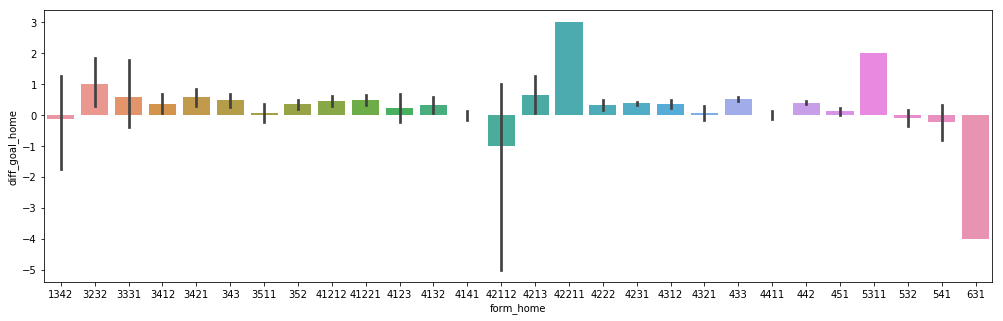

In [14]:
plt.figure(figsize=(17,5))
sns.barplot(x='form_home', y='diff_goal_home',data=matchsTrainCopy)

Explication:

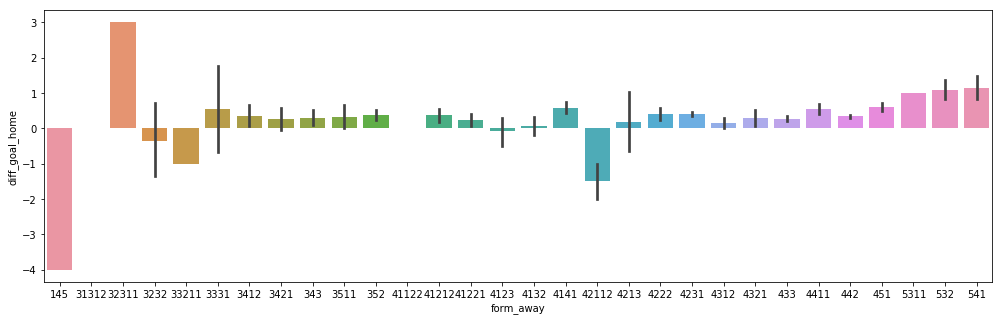

In [15]:
plt.figure(figsize=(17,5))
sns.barplot(x='form_away', y='diff_goal_home',data=matchsTrainCopy)

Explication:

## Ajout des notes générales des joueurs

Pour ajouter les notes des joueurs, nous allons créer un dictionnaire avec comme clé un tuple avec l'api id et la date et comme valeur sa note générale ( En effet, la note d'un joueur varie en fonction du temps et un même joueur a donc plusieurs notes dans la table Players Attributes

In [16]:
def create_player_overall_dict(player_attr):
    ply_attr = player_attr[['player_api_id', 'overall_rating', 'date']]
    ply_attr['date'] = ply_attr['date'].apply(lambda x: x.split('-')[0]) # on retient seulement l'année
    ply_attr = ply_attr.groupby([ply_attr['player_api_id'], ply_attr['date']]).mean()

    return ply_attr.to_dict()['overall_rating']

ply_attr_overall_dict = create_player_overall_dict(player_attr)

Dans la table Players Attributs, il est possible qu'un joueur n'ai pas une note à une certaine date. Ce qui va provoquer un crash lorsqu'on voudra acceder à cette clé là (id,date)

In [17]:
def dict_key_checker(attr_dict, api_id, date):
    if(api_id == 0):
        return 0
    try:
        res = attr_dict[(api_id, str(date))]
    except KeyError:
        date = int(date)
        dates = [int(k[1]) for k in attr_dict if k[0] == api_id]
        if not dates:  # si l'api id n'est pas présente dans le dictionnaire
            return 0
        res = attr_dict[(api_id, str(min(dates, key=lambda key: abs(key-date))))] # si la date est pas présente , 
        #on prend la date la plus proche
    return res

In [18]:
for i in range(1, 12):
    matchsTrainCopy['home_player_overall_'+str(i)] = matchsTrainCopy.apply(lambda x: 
            dict_key_checker(ply_attr_overall_dict, int(x['home_player_'+str(i)]), x['date'].split('-')[0])/99, axis=1)
    matchsTrainCopy['away_player_overall_'+str(i)] = matchsTrainCopy.apply(lambda x: 
            dict_key_checker(ply_attr_overall_dict, int(x['away_player_'+str(i)]), x['date'].split('-')[0])/99, axis=1)

Nous divisons la note par 99 car la note générale est une note entre 0 et 99. Ca nous permettera normaliser la note et se retrouver avec une valeur entre 0 et 99

In [19]:
matchsTrainCopy.head()

,index,id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,...,home_player_overall_7,away_player_overall_7,home_player_overall_8,away_player_overall_8,home_player_overall_9,away_player_overall_9,home_player_overall_10,away_player_overall_10,home_player_overall_11,away_player_overall_11
0,0,11103,2010/2011,17,2010-12-19 00:00:00,8533,9885,1,1,39477.0,...,0.727273,0.606061,0.747475,0.803030,0.696970,0.792929,0.777778,0.818182,0.686869,0.823232
1,1,16167,2009/2010,5,2009-08-29 00:00:00,8245,2186,1,1,13471.0,...,0.777778,0.727273,0.646465,0.767677,0.636364,0.787879,0.722222,0.893939,0.863636,0.777778
2,2,11222,2010/2011,28,2011-03-06 00:00:00,9882,9880,2,3,27691.0,...,0.782828,0.722222,0.717172,0.732323,0.747475,0.767677,0.752525,0.782828,0.732323,0.696970
3,3,11018,2010/2011,1,2010-08-29 00:00:00,9976,9885,1,0,41818.0,...,0.757576,0.777778,0.707071,0.808081,0.727273,0.792929,0.696970,0.823232,0.787879,0.823232
4,4,25596,2013/2014,5,2013-08-10 00:00:00,9930,10192,0,4,67374.0,...,0.601010,0.640693,0.626263,0.696970,0.572391,0.654545,0.612795,0.660895,0.851515,0.704545


In [20]:
matchsTrainCopy.corrwith(matchsTrainCopy['label']).sort_values(ascending=False)[1:]

diff_goal_home            0.859076
home_team_goal            0.620839
home_player_overall_7     0.153311
home_player_overall_8     0.145521
home_player_overall_11    0.144683
home_player_overall_3     0.142765
home_player_overall_5     0.141492
home_player_overall_2     0.140775
home_player_overall_9     0.140008
home_player_overall_4     0.138448
home_player_overall_6     0.137211
home_player_overall_10    0.131809
home_player_overall_1     0.126671
away_player_1             0.024024
away_player_3             0.016283
away_player_10            0.014090
away_team_api_id          0.013994
away_player_11            0.011715
away_player_8             0.011287
away_player_7             0.011281
away_player_2             0.011142
away_player_5             0.007451
away_player_6             0.005934
index                     0.002380
away_player_4             0.001284
stage                    -0.000140
away_player_9            -0.000236
id                       -0.011120
home_player_9       

## Ajout du potentiel des joueurs

Nous recommencons la meme manipulation pour ajouter le potentiel des joueurs

In [21]:
def create_player_pot_dict(player_attr):
    ply_attr = player_attr[['player_api_id', 'potential', 'date']]
    ply_attr['date'] = ply_attr['date'].apply(lambda x: x.split('-')[0])
    ply_attr = ply_attr.groupby([ply_attr['player_api_id'], ply_attr['date']]).mean()

    return ply_attr.to_dict()['potential']

ply_attr_pot_dict = create_player_pot_dict(player_attr)

for i in range(1, 12):
    matchsTrainCopy['home_player_potential_'+str(i)] = matchsTrainCopy.apply(lambda x: 
        dict_key_checker(ply_attr_pot_dict, int(x['home_player_'+str(i)]), x['date'].split('-')[0])/99, axis=1)
    matchsTrainCopy['away_player_potential_'+str(i)] = matchsTrainCopy.apply(lambda x: 
        dict_key_checker(ply_attr_pot_dict, int(x['away_player_'+str(i)]), x['date'].split('-')[0])/99, axis=1)

In [22]:
matchsTrainCopy.corrwith(matchsTrainCopy['label']).sort_values(ascending=False)[1:]

diff_goal_home              0.859076
home_team_goal              0.620839
home_player_overall_7       0.153311
home_player_potential_11    0.153011
home_player_potential_8     0.150988
home_player_potential_7     0.146234
home_player_overall_8       0.145521
home_player_overall_11      0.144683
home_player_potential_4     0.143203
home_player_potential_9     0.143035
home_player_overall_3       0.142765
home_player_potential_10    0.142213
home_player_overall_5       0.141492
home_player_potential_5     0.141276
home_player_overall_2       0.140775
home_player_potential_3     0.140220
home_player_overall_9       0.140008
home_player_overall_4       0.138448
home_player_potential_2     0.137440
home_player_overall_6       0.137211
home_player_potential_6     0.133960
home_player_overall_10      0.131809
home_player_potential_1     0.129822
home_player_overall_1       0.126671
away_player_1               0.024024
away_player_3               0.016283
away_player_10              0.014090
a

## Ajout des attributs defensePressure et le buildUpPlayPassing 

In [23]:
def create_team_attr_dict(teams_attr, key):
    tms_attr = teams_attr[['team_api_id', 'date','defencePressure', 'buildUpPlayPassing']]
    tms_attr['date'] = tms_attr['date'].apply(lambda x: x.split('-')[0])
    tms_attr = tms_attr.groupby([tms_attr['team_api_id'], tms_attr['date']]).mean()
    return tms_attr.to_dict()[key]

teams_buildUp_dict = create_team_attr_dict(team_attr, 'buildUpPlayPassing')
teams_def_press_dict = create_team_attr_dict(team_attr, 'defencePressure')

matchsTrainCopy['home_build_up'] = matchsTrainCopy.apply(lambda x: 
        dict_key_checker(teams_buildUp_dict, x['home_team_api_id'], x['date'].split('-')[0])/99, axis=1)
matchsTrainCopy['away_build_up'] = matchsTrainCopy.apply(lambda x: 
        dict_key_checker(teams_buildUp_dict, x['away_team_api_id'], x['date'].split('-')[0])/99, axis=1)
matchsTrainCopy['home_def_press'] = matchsTrainCopy.apply(lambda x: 
        dict_key_checker(teams_def_press_dict, x['home_team_api_id'], x['date'].split('-')[0])/99, axis=1)
matchsTrainCopy['away_def_press'] = matchsTrainCopy.apply(lambda x: 
        dict_key_checker(teams_def_press_dict, x['away_team_api_id'], x['date'].split('-')[0])/99, axis=1)

In [24]:
matchsTrainCopy.corrwith(matchsTrainCopy['label']).sort_values(ascending=False)[1:]

diff_goal_home              0.859076
home_team_goal              0.620839
home_player_overall_7       0.153311
home_player_potential_11    0.153011
home_player_potential_8     0.150988
home_player_potential_7     0.146234
home_player_overall_8       0.145521
home_player_overall_11      0.144683
home_player_potential_4     0.143203
home_player_potential_9     0.143035
home_player_overall_3       0.142765
home_player_potential_10    0.142213
home_player_overall_5       0.141492
home_player_potential_5     0.141276
home_player_overall_2       0.140775
home_player_potential_3     0.140220
home_player_overall_9       0.140008
home_player_overall_4       0.138448
home_player_potential_2     0.137440
home_player_overall_6       0.137211
home_player_potential_6     0.133960
home_player_overall_10      0.131809
home_player_potential_1     0.129822
home_player_overall_1       0.126671
home_def_press              0.065244
away_build_up               0.034656
away_player_1               0.024024
a

## Exploitation des notes générales / potentiel des joueurs et de la formation

Une idée que l'on pourrait avoir pour réduire le nombre de colonnes du training set est, grace à la formation, de faire une moyenne des notes d'une équipe par ligne ( défense , milieu et attaque)  

In [25]:
def get_nbr_players_by_lines(form):
    list_form = list(form)
    list_form = [int(x) for x in list_form]
    defenders = list_form[0] + 1  # plus le gardien
    attackers = list_form[-1]
    midfielders = sum(list_form[1:-1])
    return defenders, midfielders, attackers

In [26]:
for index, row in matchsTrainCopy.iterrows():
    nbr_def_home, nbr_mid_home, nbr_att_home = get_nbr_players_by_lines(row['form_home'])
    nbr_def_away, nbr_mid_away, nbr_att_away = get_nbr_players_by_lines(row['form_away'])

    # Overall
    matchsTrainCopy.loc[index, 'home_def_overall'] = row.loc[[
                'home_player_overall_' + str(i) for i in range(1, nbr_def_home+1)]].mean()
    matchsTrainCopy.loc[index, 'home_mid_overall'] = row.loc[[
                'home_player_overall_' + str(i) for i in range(nbr_def_home+1, nbr_def_home + nbr_mid_home+1)]].mean()
    matchsTrainCopy.loc[index, 'home_att_overall'] = row.loc[[
                'home_player_overall_' + str(i) for i in range(nbr_def_home + nbr_mid_home+1, 12)]].mean()

    matchsTrainCopy.loc[index, 'away_def_overall'] = row.loc[[
                'away_player_overall_' + str(i) for i in range(1, nbr_def_away+1)]].mean()
    matchsTrainCopy.loc[index, 'away_mid_overall'] = row.loc[[
                'away_player_overall_' + str(i) for i in range(nbr_def_away+1, nbr_def_away + nbr_mid_away+1)]].mean()
    matchsTrainCopy.loc[index, 'away_att_overall'] = row.loc[[
                'away_player_overall_' + str(i) for i in range(nbr_def_away + nbr_mid_away+1, 12)]].mean()


    # Potential
    matchsTrainCopy.loc[index, 'home_def_pot'] = row.loc[[
        'home_player_potential_' + str(i) for i in range(1, nbr_def_home+1)]].mean()
    matchsTrainCopy.loc[index, 'home_mid_pot'] = row.loc[[
        'home_player_potential_' + str(i) for i in range(nbr_def_home+1, nbr_def_home + nbr_mid_home+1)]].mean()
    matchsTrainCopy.loc[index, 'home_att_pot'] = row.loc[[
        'home_player_potential_' + str(i) for i in range(nbr_def_home + nbr_mid_home+1, 12)]].mean()

    matchsTrainCopy.loc[index, 'away_def_pot'] = row.loc[[
        'away_player_potential_' + str(i) for i in range(1, nbr_def_away+1)]].mean()
    matchsTrainCopy.loc[index, 'away_mid_pot'] = row.loc[[
        'away_player_potential_' + str(i) for i in range(nbr_def_away+1, nbr_def_away + nbr_mid_away+1)]].mean()
    matchsTrainCopy.loc[index, 'away_att_pot'] = row.loc[[
        'away_player_potential_' + str(i) for i in range(nbr_def_away + nbr_mid_away+1, 12)]].mean()


KeyboardInterrupt: 

In [ ]:
#On supprime les colonnes qui ne nous serviront plus
matchsTrainCopy.drop(matchsTrainCopy.select(lambda col: col.startswith('home_player'), axis=1), axis=1, inplace=True)
matchsTrainCopy.drop(matchsTrainCopy.select(lambda col: col.startswith('away_player'), axis=1), axis=1, inplace=True)

In [ ]:
matchsTrainCopy.info()

In [ ]:
matchsTrainCopy.corrwith(matchsTrainCopy['label']).sort_values(ascending=False)[1:]

## Rapport entre les attributs de l'équipe à domicile et à l'extérieur

L'idée ici sera d'effectuer un rapport (une difference) entre les colonnes des differents attributs des équipes domicile et extérieur. En effet cette difference, si elle est positif représentera une correlation positive avec le label , si négative une correlation négative

In [ ]:
matchsTrainCopy['diff_def_overall'] = matchsTrainCopy['home_def_overall'] - matchsTrainCopy['away_def_overall']
matchsTrainCopy['diff_mid_overall'] = matchsTrainCopy['home_mid_overall'] - matchsTrainCopy['away_mid_overall']
matchsTrainCopy['diff_att_overall'] = matchsTrainCopy['home_att_overall'] - matchsTrainCopy['away_att_overall']

matchsTrainCopy['diff_att_home_def_away'] = matchsTrainCopy['home_att_overall'] - matchsTrainCopy['away_def_overall']
matchsTrainCopy['diff_def_home_att_away'] = matchsTrainCopy['home_def_overall'] - matchsTrainCopy['away_att_overall']

matchsTrainCopy['diff_def_pot'] = matchsTrainCopy['home_def_pot'] - matchsTrainCopy['away_def_pot']
matchsTrainCopy['diff_mid_pot'] = matchsTrainCopy['home_mid_pot'] - matchsTrainCopy['away_mid_pot']
matchsTrainCopy['diff_att_pot'] = matchsTrainCopy['home_att_pot'] - matchsTrainCopy['away_att_pot']


matchsTrainCopy['diff_build_up'] = matchsTrainCopy['home_build_up'] - matchsTrainCopy['away_build_up']
matchsTrainCopy['diff_def_press'] = matchsTrainCopy['home_def_press'] - matchsTrainCopy['away_def_press']


In [ ]:
matchsTrainCopy.info()

In [ ]:
"""matchsTrainCopy = matchsTrainCopy.drop(['home_build_up','away_build_up','home_def_press','away_def_press','home_def_overall',
                                     'home_mid_overall','home_att_overall','away_def_overall','away_mid_overall',
                                     'away_att_overall','home_def_pot','home_mid_pot','home_att_pot','away_def_pot',
                                     'away_mid_pot','away_att_pot'], axis=1)"""


In [ ]:
matchsTrainCopy.info()

In [ ]:
matchsTrainCopy.corrwith(matchsTrainCopy['label']).sort_values(ascending=False)[1:]

In [ ]:
# Exportation de la dataframe sous csv
matchsTrainCopy.to_csv(r'../csv/matchsTrainEngineered.csv')

### Visualisation

In [ ]:
matchsTrainCopy = matchsTrainCopy.drop(['index', 'home_team_api_id', 'away_team_api_id', 'stage'], axis=1)

In [ ]:
#Difference de but entre l'équipe à domicile et à l'extérieur
matchsTrainCopy['diff_goal_home'] = matchsTrainCopy['home_team_goal'] - matchsTrainCopy['away_team_goal']
sns.jointplot(x = 'diff_att_home_def_away' , y='diff_goal_home' , data=matchsTrainCopy)

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(matchsTrainCopy.corr(),annot=True,cmap='coolwarm', linewidths=1)

### Idées de transformation des données qui n'ont pas abouties
- Prendre des données statistiques à partir du training set comme le nombre totals des buts inscrits par une equipe , le nombre de victoire à domicile , le taux de victoire d'une équipe ou le aux de victoire d'une équipe à domicile dans les confrontations direct avec l'équipe extérieur => ces données repésentaient un risque d'overfitting c'est pourquoi cette idée n'a pas aboutie
- 